#  Random Forest and GBDT on DonorsChoose

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible How to increase the consistency of project vetting across different volunteers to improve the experience for teachers How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py
from scipy.sparse import hstack
import chart_studio.plotly as py


from collections import Counter

## 1. LOAD AND PROCESS DATA

### 1.1 Reading Data

In [2]:
data=pd.read_csv("train_data.csv",nrows=50000)
resource_data=pd.read_csv("resources.csv")
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
price_data=resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [4]:
project_data=pd.merge(data, price_data, on='id', how='left')

In [5]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

### 1.2 process Project Essay

In [6]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22


In [7]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                project_data["project_essay_2"].map(str) + \
                project_data["project_essay_3"].map(str) + \
                project_data["project_essay_4"].map(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['cleaned_essay']=preprocessed_essays

100%|██████████| 50000/50000 [00:26<00:00, 1888.95it/s]


### 1.2 process Project Title

In [11]:
# https://stackoverflow.com/a/47091490/4084039
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
project_data['cleaned_project_title']=preprocessed_title

100%|██████████| 50000/50000 [00:01<00:00, 38272.34it/s]


### 1.3 teacher_prefix

In [12]:
temp1=data.teacher_prefix.apply(lambda x: str(x).replace('.', ''))
project_data['teacher_prefix']=temp1
project_data['teacher_prefix'].value_counts()


Mrs        26140
Ms         17936
Mr          4859
Teacher     1061
nan            2
Dr             2
Name: teacher_prefix, dtype: int64

### 1.4 project grade

In [13]:
project_data.project_grade_category.value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

In [14]:
grade_list=[]
for i in project_data['project_grade_category'].values:
    i=i.replace(' ','_')
    i=i.replace('-','_')
    grade_list.append(i.strip()) 
    
    
project_data['project_grade_category']=grade_list  
       
   

In [15]:
project_data['project_grade_category'].value_counts()

Grades_PreK_2    20316
Grades_3_5       16968
Grades_6_8        7750
Grades_9_12       4966
Name: project_grade_category, dtype: int64

### 1.5 project_subject_categories

In [16]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.6 project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.7 counting words in title

In [18]:
#https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
project_data['totalwords_title'] = project_data['cleaned_project_title'].str.split().str.len()

### 1.8 number of words in the essay

In [19]:
project_data['totalwords_essay'] = project_data['cleaned_essay'].str.split().str.len()

### 1.9 sentiment score's of each of the essay

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
neg=[]
compound=[]
pos=[]
neu=[]
for sent in (project_data['cleaned_essay'].values):
    score = analyser.polarity_scores(sent)
    neg.append(score.get('neg'))
    neu.append(score.get('neu'))
    pos.append(score.get('pos'))
    compound.append(score.get('compound'))
project_data['neg']=neg
project_data['neu']=neu
project_data['pos']=pos
project_data['compound']=compound

### 1.10 droping unnecesarry columns

In [21]:
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [22]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.11 Making dependant(label) and independant variables

In [23]:
y = project_data['project_is_approved'].values

project_data.head(1)
x=project_data
x.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.12 Traing and Test split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)

#X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train, test_size=0.33, stratify=Y_train,random_state=42)

## 2.Text Vectorization and encoding catagories,normalization numerical features

### 2.1 converting the essay to vectors using BOW

In [28]:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['cleaned_essay'].values)
#X_cv_essay_bow = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, Y_train.shape)
print(X_test_essay_bow.shape, Y_test.shape)
print(X_cv_essay_bow.shape, Y_cv.shape)
print("="*100)

After vectorizations
(22445, 5000) (22445,)
(16500, 5000) (16500,)
(11055, 5000) (11055,)


### 2.2 converting the title to vectors using BOW

In [29]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['cleaned_project_title'].values)
#X_cv_title_bow = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, Y_train.shape)
print(X_cv_title_bow.shape, Y_cv.shape)
print(X_test_title_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 2004) (22445,)
(11055, 2004) (11055,)
(16500, 2004) (16500,)


### 2.3 converting the title to vectors using TFIDF

In [31]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['cleaned_project_title'].values)
#X_cv_title_tfidf = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, Y_train.shape)
print(X_cv_title_tfidf.shape, Y_cv.shape)
print(X_test_title_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1229) (22445,)
(11055, 1229) (11055,)
(16500, 1229) (16500,)


### 2.4 converting the essay to vectors using TFIDF

In [32]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['cleaned_essay'].values)
#X_cv_essay_tfidf = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, Y_train.shape)
print(X_cv_essay_tfidf.shape, Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 8869) (22445,)
(11055, 8869) (11055,)
(16500, 8869) (16500,)


### 2.5 load glove mode

In [33]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
'''Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!
'''
# ============================

1544it [00:00, 7538.34it/s]

Loading Glove Model


1917495it [03:58, 8038.90it/s]

Done. 1917495  words loaded!


'Output:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n'

In [34]:

words = []
for i in X_train['cleaned_essay'].values:
    words.extend(i.split(' '))

for i in X_train['cleaned_project_title'].values:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 3499621
the unique words in the coupus 31643
The number of words that are present in both glove vectors and our coupus 29734 ( 93.967 %)
word 2 vec length 29734


In [35]:

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### 2.6 Avg w2v on essay

In [36]:
Text_avg_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_essay.append(vector)

print(len(Text_avg_w2v_train_essay))
print(len(Text_avg_w2v_train_essay[0]))

100%|██████████| 22445/22445 [00:07<00:00, 3001.38it/s]

22445
300


In [37]:
''''Text_avg_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_essay.append(vector)

print(len(Text_avg_w2v_cv_essay))
print(len(Text_avg_w2v_cv_essay[0]))

100%|██████████| 11055/11055 [00:03<00:00, 2936.08it/s]

11055
300


In [38]:
Text_avg_w2v_test_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_essay.append(vector)

print(len(Text_avg_w2v_test_essay))
print(len(Text_avg_w2v_test_essay[0]))

100%|██████████| 16500/16500 [00:05<00:00, 3068.97it/s]

16500
300


### 2.7 Avg w2v on title

In [39]:
Text_avg_w2v_train_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_title.append(vector)

print(len(Text_avg_w2v_train_title))
print(len(Text_avg_w2v_train_title[0]))

100%|██████████| 22445/22445 [00:00<00:00, 64112.56it/s]

22445
300


In [40]:
'''''Text_avg_w2v_cv_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_title.append(vector)

print(len(Text_avg_w2v_cv_title))
print(len(Text_avg_w2v_cv_title[0]))

100%|██████████| 11055/11055 [00:00<00:00, 62313.07it/s]

11055
300


In [41]:
Text_avg_w2v_test_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_title.append(vector)

print(len(Text_avg_w2v_test_title))
print(len(Text_avg_w2v_test_title[0]))

100%|██████████| 16500/16500 [00:00<00:00, 63445.37it/s]

16500
300


### 2.4 TFIDF weighted W2V on essay

In [47]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [48]:

Text_tfidf_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_essay.append(vector)

print(len(Text_tfidf_w2v_train_essay))
print(len(Text_tfidf_w2v_train_essay[0]))

100%|██████████| 22445/22445 [00:55<00:00, 401.57it/s]

22445
300


In [49]:

'''''Text_tfidf_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_essay.append(vector)

print(len(Text_tfidf_w2v_cv_essay))
print(len(Text_tfidf_w2v_cv_essay[0]))

100%|██████████| 11055/11055 [00:27<00:00, 406.31it/s]

11055
300


In [50]:
Text_tfidf_w2v_test_essay= []; 
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_essay.append(vector)

print(len(Text_tfidf_w2v_test_essay))
print(len(Text_tfidf_w2v_test_essay[0]))

100%|██████████| 16500/16500 [00:40<00:00, 411.46it/s]

16500
300


### 2.5 TFIDF weighted W2V on title

In [51]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [52]:

Text_tfidf_w2v_train_title= []; 
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_title.append(vector)

print(len(Text_tfidf_w2v_train_title))
print(len(Text_tfidf_w2v_train_title[0]))

100%|██████████| 22445/22445 [00:00<00:00, 28213.44it/s]

22445
300


In [53]:

'''''Text_tfidf_w2v_cv_title= []; 
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_title.append(vector)

print(len(Text_tfidf_w2v_cv_title))
print(len(Text_tfidf_w2v_cv_title[0]))

100%|██████████| 11055/11055 [00:00<00:00, 29009.32it/s]

11055
300


In [54]:
Text_tfidf_w2v_test_title= []; 
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_title.append(vector)

print(len(Text_tfidf_w2v_test_title))
print(len(Text_tfidf_w2v_test_title[0]))

100%|██████████| 16500/16500 [00:00<00:00, 28295.55it/s]

16500
300


In [55]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'essay', 'cleaned_essay', 'cleaned_project_title',
       'clean_categories', 'clean_subcategories', 'totalwords_title',
       'totalwords_essay', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

### 2.6 Categories with response coding

In [56]:
def Responsetable(table, col) :
    cat = table[col].unique()
    alpha=1
    freq_Pos = []
    for i in cat : 
        freq_Pos.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 1)]))
        
        
    freq_Neg = []
    for i in cat : 
        freq_Neg.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 0)]))
        
    
    encoded_Pos = []
    for i in range(len(cat)) :
        encoded_Pos.append(((freq_Pos[i]+alpha)/(freq_Pos[i] + freq_Neg[i]+alpha)))
    
    encoded_Neg = []
    encoded_Neg[:] = [1 - x for x in encoded_Pos]
        
    encoded_Pos_val = dict(zip(cat, encoded_Pos)) 
    encoded_Neg_val = dict(zip(cat, encoded_Neg)) 
    
    return encoded_Pos_val, encoded_Neg_val

In [57]:
def Responsecode(table) : 
    pos_cleancat, neg_cleancat = Responsetable(table,'clean_categories')
    pos_cleansubcat, neg_cleansubcat = Responsetable(table,'clean_subcategories')
    pos_schoolstate, neg_schoolstate = Responsetable(table, 'school_state')
    pos_teacherprefix, neg_teacherprefix = Responsetable(table, 'teacher_prefix')
    pos_projgradecat, neg_projgradecat = Responsetable(table, 'project_grade_category')
    
    df = pd.DataFrame()
    df['clean_cat_pos'] = table['clean_categories'].map(pos_cleancat)
    df['clean_cat_neg'] = table['clean_categories'].map(neg_cleancat)
    df['clean_subcat_pos'] = table['clean_subcategories'].map(pos_cleansubcat)
    df['clean_subcat_neg'] = table['clean_subcategories'].map(neg_cleansubcat)
    df['school_state_pos'] = table['school_state'].map(pos_schoolstate)
    df['school_state_neg'] = table['school_state'].map(neg_schoolstate)
    df['teacher_prefix_pos'] = table['teacher_prefix'].map(pos_teacherprefix)
    df['teacher_prefix_neg'] = table['teacher_prefix'].map(neg_teacherprefix)
    df['proj_grade_cat_pos'] = table['project_grade_category'].map(pos_projgradecat)
    df['proj_grade_cat_neg'] = table['project_grade_category'].map(neg_projgradecat)

    return df

In [59]:
newTrain = Responsecode(X_train)
newTest = Responsecode(X_test)
#newCv=Responsecode(X_cv)

In [60]:
def mergeEncoding(table, p, n) :
    lstPos = table[p].values.tolist()
    lstNeg = table[n].values.tolist()
    frame = pd.DataFrame(list(zip(lstNeg, lstPos)))
    
    return frame

### 2.7  response code of clean_categories

In [61]:
X_train_clean_cat_resposecode = mergeEncoding(newTrain, 'clean_cat_pos', 'clean_cat_neg')
X_test_clean_cat_resposecode = mergeEncoding(newTest, 'clean_cat_pos', 'clean_cat_neg')
#X_cv_clean_cat_resposecode=mergeEncoding(newCv, 'clean_cat_pos', 'clean_cat_neg')
print(X_train_clean_cat_resposecode.shape)

(22445, 2)


### 2.8 response code of clean_sub_categories

In [63]:
X_train_clean_subcat_resposecode = mergeEncoding(newTrain, 'clean_subcat_pos', 'clean_subcat_neg')
X_test_clean_subcat_resposecode = mergeEncoding(newTest, 'clean_subcat_pos', 'clean_subcat_neg')
#X_cv_clean_subcat_resposecode = mergeEncoding(newCv, 'clean_subcat_pos', 'clean_subcat_neg')
print(X_train_clean_subcat_resposecode.shape)
print(X_test_clean_subcat_resposecode.shape)
#print(X_cv_clean_subcat_resposecode.shape)

(22445, 2)
(16500, 2)
(11055, 2)


### 2.9 response code of project grade

In [64]:
X_train_grade_resposecode = mergeEncoding(newTrain, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
X_test_grade_resposecode = mergeEncoding(newTest, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
#X_cv_grade_resposecode = mergeEncoding(newCv, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
print(X_train_grade_resposecode.shape)
print(X_test_grade_resposecode.shape)
#print(X_cv_grade_resposecode.shape)

(22445, 2)
(16500, 2)
(11055, 2)


### 2.10 response code of school state

In [66]:
X_train_state_resposecode = mergeEncoding(newTrain, 'school_state_pos', 'school_state_neg')
X_test_state_resposecode = mergeEncoding(newTest, 'school_state_pos', 'school_state_neg')
#X_cv_state_resposecode = mergeEncoding(newCv, 'school_state_pos', 'school_state_neg')
print(X_train_state_resposecode.shape)
print(X_test_state_resposecode.shape)
#print(X_cv_state_resposecode.shape)

(22445, 2)
(16500, 2)
(11055, 2)


### 2.11 response code of teacher prefix

In [65]:
X_train_teacher_resposecode = mergeEncoding(newTrain, 'teacher_prefix_pos', 'teacher_prefix_neg')
X_test_teacher_resposecode = mergeEncoding(newTest, 'teacher_prefix_pos', 'teacher_prefix_neg')
#X_cv_teacher_resposecode = mergeEncoding(newCv, 'teacher_prefix_pos', 'teacher_prefix_neg')
print(X_train_teacher_resposecode.shape)
print(X_test_teacher_resposecode.shape)
#print(X_cv_teacher_resposecode.shape)

(22445, 2)
(16500, 2)
(11055, 2)


### 2.12 Normalizing the numerical features: Price

In [68]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
#print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 2.13 Normalizing the numerical features:teacher_number_of_previously_posted_projects

In [69]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_TPPP_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, Y_train.shape)
#print(X_cv_TPPP_norm.shape, Y_cv.shape)
print(X_test_TPPP_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 2.14 Normalizing the numerical features: quantity

In [70]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
#X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, Y_train.shape)
#print(X_cv_quantity_norm.shape, Y_cv.shape)
print(X_test_quantity_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 2.15 Normalizing the numerical features: totalwords_title

In [71]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_totalwords_title_norm = normalizer.transform(X_train['totalwords_title'].values.reshape(-1,1))

X_test_totalwords_title_norm = normalizer.transform(X_test['totalwords_title'].values.reshape(-1,1))
#X_cv_totalwords_title_norm = normalizer.transform(X_cv['totalwords_title'].values.reshape(-1,1))
print("After vectorizations")
print(X_train_totalwords_title_norm.shape, Y_train.shape)
#print(X_cv_totalwords_title_norm.shape, Y_cv.shape)
print(X_test_totalwords_title_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 2.17 Normalizing the numerical features: totalwords_essay

In [72]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_totalwords_essay_norm = normalizer.transform(X_train['totalwords_essay'].values.reshape(-1,1))
#X_cv_totalwords_essay_norm = normalizer.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_totalwords_essay_norm = normalizer.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_essay_norm.shape, Y_train.shape)
#print(X_cv_totalwords_essay_norm.shape, Y_cv.shape)
print(X_test_totalwords_essay_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


## 3. Random Forest on BOW

In [76]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]

    
    #(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)    
    return predictions

In [77]:
def myplot_matrix1(data):
    plt.clf()
    plt.imshow(data, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Approved not approved matrix')
    tick_marks = np.arange(len(classNames))
    
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FN'], ['FP', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
    plt.show()

### 3.1 BOW:Concatinating all the features

In [89]:
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_essay_bow,X_train_title_bow,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm)).tocsr()
#X_cr_bow = hstack((X_cv_essay_bow,X_cv_title_bow,X_cv_clean_cat_resposecode,X_cv_clean_subcat_resposecode,X_cv_grade_resposecode,X_cv_state_resposecode,X_cv_teacher_resposecode,X_cv_price_norm,X_cv_TPPP_norm,X_cv_quantity_norm)).tocsr()

X_te_bow = hstack((X_test_essay_bow,X_test_title_bow,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, Y_train.shape)
#print(X_cr_bow.shape, Y_cv.shape)
print(X_te_bow.shape, Y_test.shape)
print("="*100)

Final Data matrix
(22445, 7017) (22445,)
(11055, 7017) (11055,)
(16500, 7017) (16500,)


In [97]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

RF = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
model = GridSearchCV(RF, parameters, cv=3, scoring='roc_auc',return_train_score=True)
bow= model.fit(X_tr_bow, Y_train)

bow.cv_results_.keys()

print(bow.best_estimator_)
#Mean cross-validated score of the best_estimator
print(bow.score(X_tr_bow,Y_train))
print(bow.score(X_te_bow,Y_test))



RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=1000)
0.8656591637660408
0.6992449154842851


In [98]:
bow.cv_results_.keys()



dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [104]:
best_parameters=[{'n_estimators': [1000], 'max_depth':[10]}]


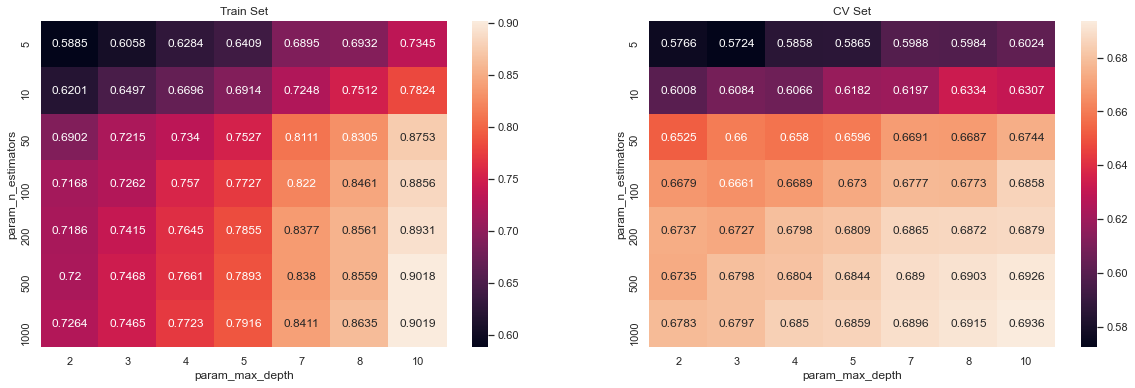

In [102]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(bow.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show() 


### observations
1.Good corelation between max depth 10 and sn_estimators 1000

2.Good corelation between max depth 10 and sample split 1000

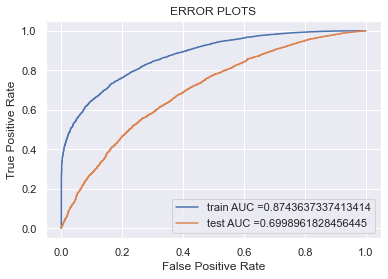

In [105]:

from sklearn.metrics import roc_curve, auc
clf11 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_parameters)
clf11.fit(X_tr_bow, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = clf11.predict_proba(X_tr_bow) [:,1]
y_test_pred = clf11.predict_proba(X_te_bow) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

### observation
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

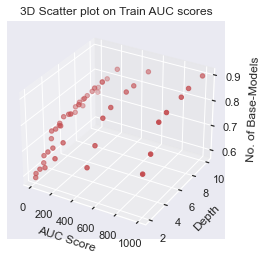

In [106]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,5,5,10,10,10,10,10,10,10,50,50,50,50,50,50,50,100,100,100,100,100,100,100,200,200,200,200,200,200,200,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000]
second = [2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10]
third = list(bow.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [107]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_bow=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_bow)
print("="*100)


Train confusion matrix
[[ 2858   605]
 [ 4898 14084]]
Accuracy score  for Train
0.7548229004232568
Test confusion matrix
[[ 1159  1387]
 [ 2741 11213]]
Accuracy score  for Test
0.7498181818181818


confusion matrix for train data


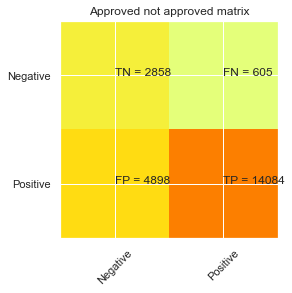

confusion matrix for Test data


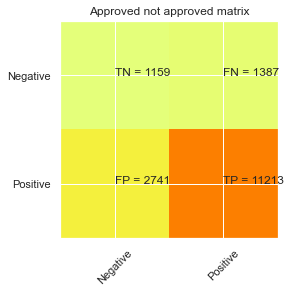

In [108]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 75% and test data is 74%.

### 3.2 TFIDF:Concatinating all the features

In [109]:
X_tr_tfidf = hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm)).tocsr()

X_te_tfidf = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)

print(X_te_tfidf.shape, Y_test.shape)
print("="*100)

Final Data matrix
(22445, 10111) (22445,)
(16500, 10111) (16500,)


In [110]:

model = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf2 = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
tfidf = clf2.fit(X_tr_tfidf, Y_train)

print(tfidf.best_score_)
print(tfidf.best_estimator_)
print(tfidf.best_params_)

0.6949762987674836
RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=5, n_estimators=1000)
{'max_depth': 8, 'n_estimators': 1000}


In [111]:
clf2.cv_results_.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

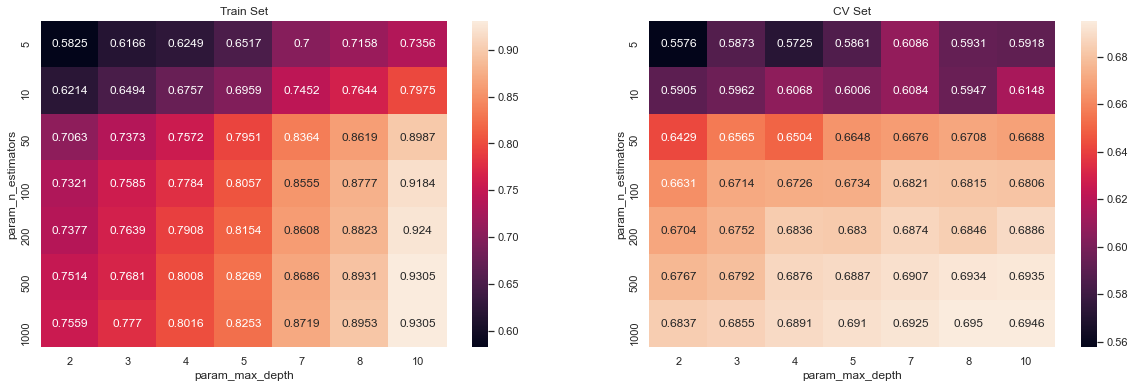

In [112]:


max_scores1 = pd.DataFrame(clf2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show() 


### observations
1.Good corelation between max depth 10 and sn_estimators 1000

2.Good corelation between max depth 10 and sample split 1000

In [113]:
best_parameters=[{'n_estimators': [1000], 'max_depth':[8]}]

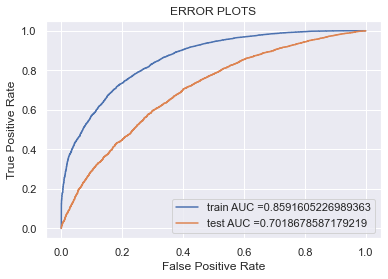

In [114]:

from sklearn.metrics import roc_curve, auc
clf2 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_parameters)
clf2.fit(X_tr_tfidf, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = clf2.predict_proba(X_tr_tfidf) [:,1]
y_test_pred = clf2.predict_proba(X_te_tfidf) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

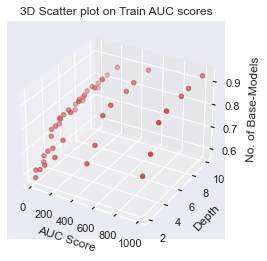

In [115]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,5,5,10,10,10,10,10,10,10,50,50,50,50,50,50,50,100,100,100,100,100,100,100,200,200,200,200,200,200,200,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000]
second = [2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10]
third = list(tfidf.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [116]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidf=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidf)
print("="*100)


Train confusion matrix
[[ 2632   831]
 [ 4172 14810]]
Accuracy score  for Train
0.7770995767431499
Test confusion matrix
[[ 1228  1318]
 [ 2870 11084]]
Accuracy score  for Test
0.7461818181818182


confusion matrix for train data


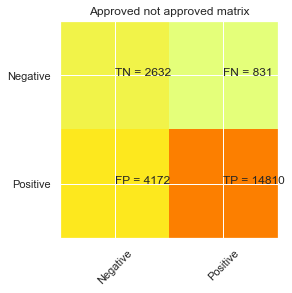

confusion matrix for Test data


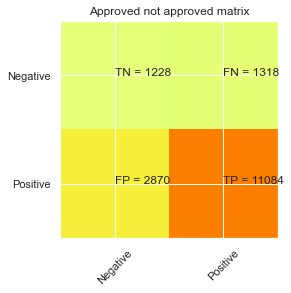

In [117]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 77% and test data is 74%.

### 3.3 avgw2v:Concatinating all the features

In [118]:
X_tr_avgw2v = np.hstack((Text_avg_w2v_train_essay,Text_avg_w2v_train_title,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm))

X_te_avgw2v = np.hstack((Text_avg_w2v_test_essay,Text_avg_w2v_test_title,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm))

print("Final Data matrix")
print(X_tr_avgw2v.shape, Y_train.shape)

print(X_te_avgw2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(22445, 613) (22445,)
(16500, 613) (16500,)


In [119]:
model = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf1 = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
avgw2v = clf1.fit(X_tr_avgw2v, Y_train)

print(avgw2v.best_score_)
print(avgw2v.best_estimator_)
print(avgw2v.best_params_)

0.6842236912759052
RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=5, n_estimators=1000)
{'max_depth': 7, 'n_estimators': 1000}


In [120]:
clf1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

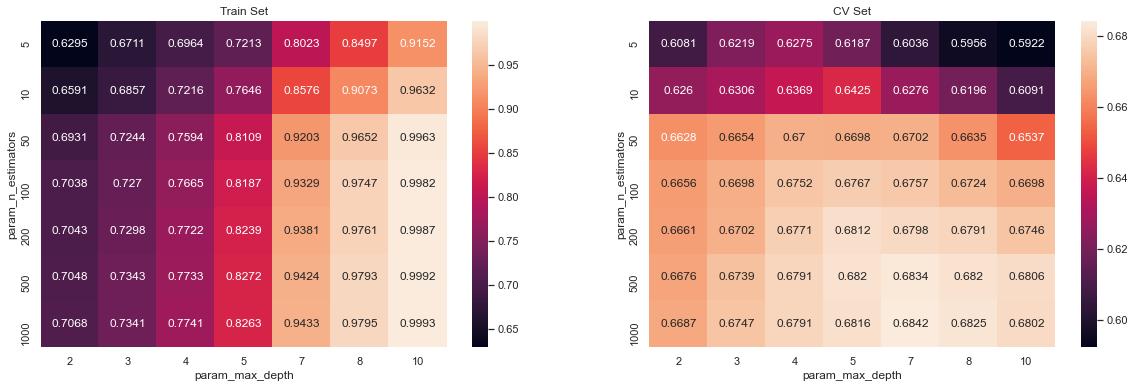

In [121]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show() 

### observations
1.Good corelation between max depth 10 and sn_estimators 1000

2.Good corelation between max depth 7 and sample split 1000

In [124]:
best_parameters=[{'n_estimators': [1000], 'max_depth':[7]}]

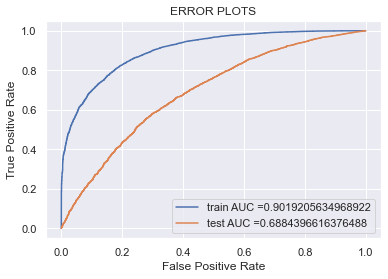

In [125]:
from sklearn.metrics import roc_curve, auc
clf2 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_parameters)
clf2.fit(X_tr_avgw2v, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = clf2.predict_proba(X_tr_avgw2v) [:,1]
y_test_pred = clf2.predict_proba(X_te_avgw2v) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

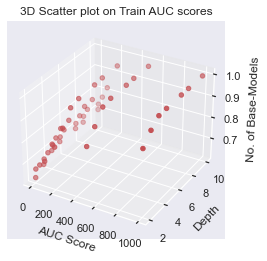

In [126]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,5,5,10,10,10,10,10,10,10,50,50,50,50,50,50,50,100,100,100,100,100,100,100,200,200,200,200,200,200,200,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000]
second = [2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10]
third = list(avgw2v.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [127]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidf=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidf)
print("="*100)


Train confusion matrix
[[ 2792   671]
 [ 3348 15634]]
Accuracy score  for Train
0.8209400757406995
Test confusion matrix
[[  988  1558]
 [ 2070 11884]]
Accuracy score  for Test
0.7801212121212121


confusion matrix for train data


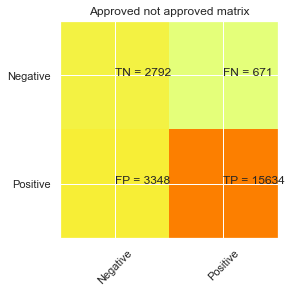

confusion matrix for Test data


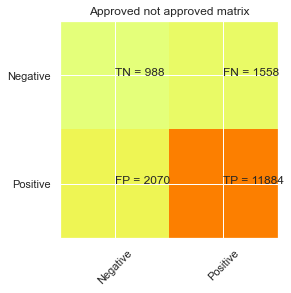

In [128]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations

1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 82% and test data is 78%.

## 3.4 TFIDFw2v

In [129]:
X_tr_tfidfw2v = np.hstack((Text_tfidf_w2v_train_essay,Text_tfidf_w2v_train_title,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm))

X_te_tfidfw2v = np.hstack((Text_tfidf_w2v_test_essay,Text_tfidf_w2v_test_title,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm))

print("Final Data matrix")
print(X_tr_tfidfw2v.shape, Y_train.shape)

print(X_te_tfidfw2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(22445, 613) (22445,)
(16500, 613) (16500,)


In [130]:
model = RandomForestClassifier(class_weight='balanced',min_samples_split=5)
parameters = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000], 'max_depth':[2, 3, 4, 5, 7, 8, 10]}
clf3 = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
tfidfw2v = clf3.fit(X_tr_tfidfw2v, Y_train)

print(tfidfw2v.best_score_)
print(tfidfw2v.best_estimator_)
print(tfidfw2v.best_params_)

0.6787674568567095
RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=5, n_estimators=1000)
{'max_depth': 7, 'n_estimators': 1000}


In [131]:
clf3.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

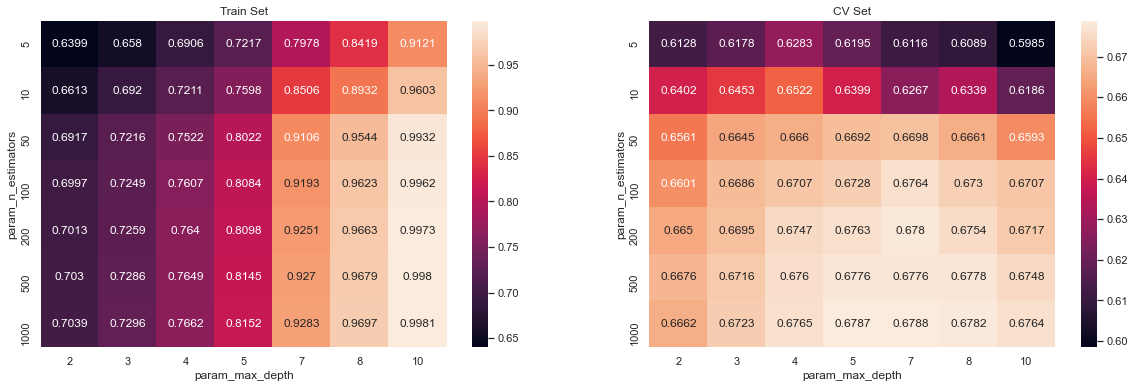

In [132]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf3.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show() 

### observations
1.Good corelation between max depth 10 and sn_estimators 1000

2.Good corelation between max depth 7 and sample split 1000

In [ ]:
best_parameters=[{'n_estimators': [1000], 'max_depth':[7]}]

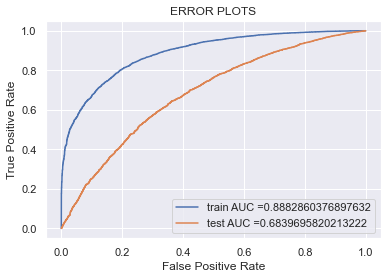

In [133]:
from sklearn.metrics import roc_curve, auc
clf2 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_parameters)
clf2.fit(X_tr_tfidfw2v, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = clf2.predict_proba(X_tr_tfidfw2v) [:,1]
y_test_pred = clf2.predict_proba(X_te_tfidfw2v) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

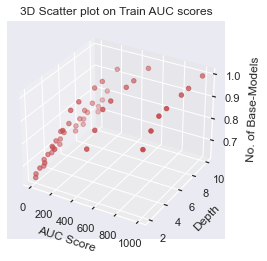

In [134]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,5,5,10,10,10,10,10,10,10,50,50,50,50,50,50,50,100,100,100,100,100,100,100,200,200,200,200,200,200,200,500,500,500,500,500,500,500,1000,1000,1000,1000,1000,1000,1000]
second = [2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10,2, 3, 4, 5, 7, 8, 10]
third = list(tfidfw2v.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [135]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 2791   672]
 [ 3774 15208]]
Accuracy score  for Train
0.8019157941635108
Test confusion matrix
[[ 1045  1501]
 [ 2435 11519]]
Accuracy score  for Test
0.7614545454545455


confusion matrix for train data


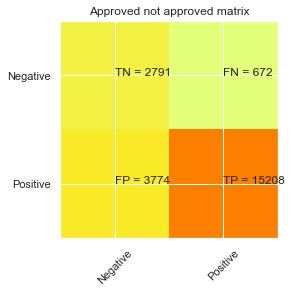

confusion matrix for Test data


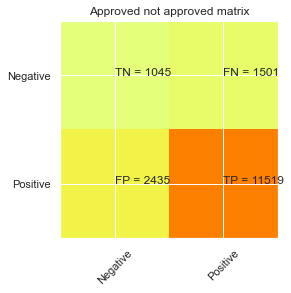

In [136]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 80% and test data is 76%.

## 4.GBDT on all vectors.

## 4.1 GBDT on Bow

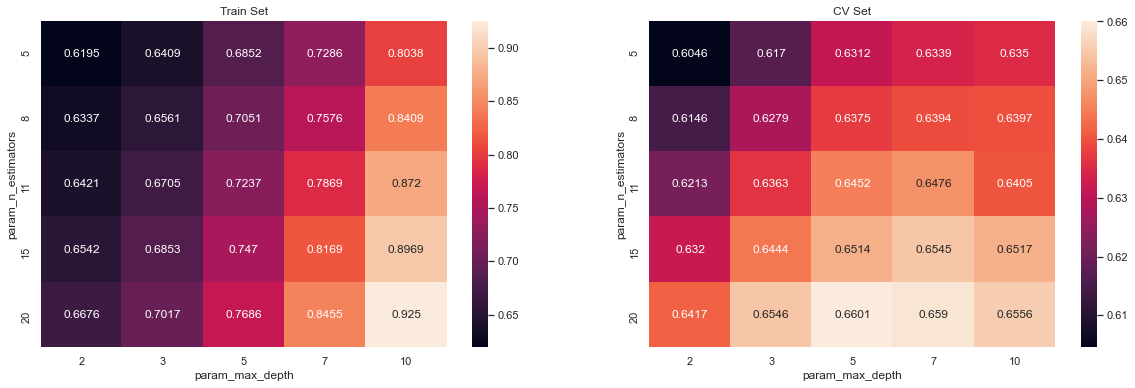

In [137]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
bow_gbdt = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
bow_gbdt .fit(X_tr_bow, Y_train)



max_scores1 = pd.DataFrame(bow_gbdt .cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

### observations
1.Good corelation between max depth 10 and sn_estimators 20

2.Good corelation between max depth 5 and sample split 20

In [140]:
print(bow_gbdt.best_estimator_)
#Mean cross-validated score of the best_estimator
print(bow_gbdt.score(X_tr_bow,Y_train))
print(bow_gbdt.score(X_te_bow,Y_test))

GradientBoostingClassifier(max_depth=5, min_samples_split=15, n_estimators=20)
0.7534518468535307
0.6739213464372502


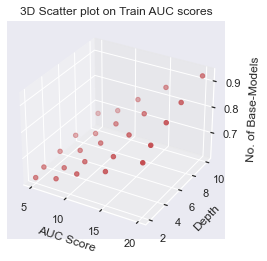

In [146]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,8,8,8,8,8,11,11,11,11,11,15,15,15,15,15,20,20,20,20,20]
second = [2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10]
third = list(bow_gbdt.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [166]:
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

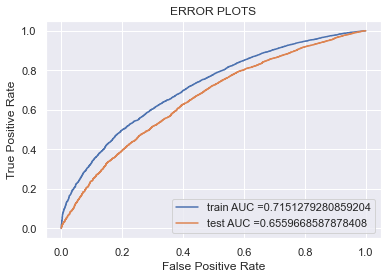

In [167]:
model1 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
model1.fit(X_tr_bow, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = model1.predict_proba(X_tr_bow) [:,1]
y_test_pred = model1.predict_proba(X_te_bow) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

In [168]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 2357  1106]
 [ 7113 11869]]
Accuracy score  for Train
0.6338159946535977
Test confusion matrix
[[1660  886]
 [6135 7819]]
Accuracy score  for Test
0.5744848484848485


confusion matrix for train data


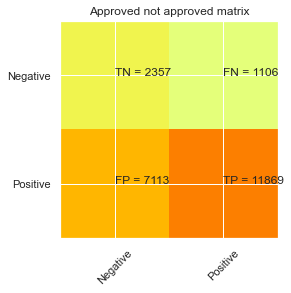

confusion matrix for Test data


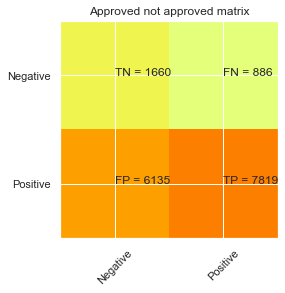

In [169]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations

1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 63% and test data is 57%.

## 4.2 GBDT on TFIDF

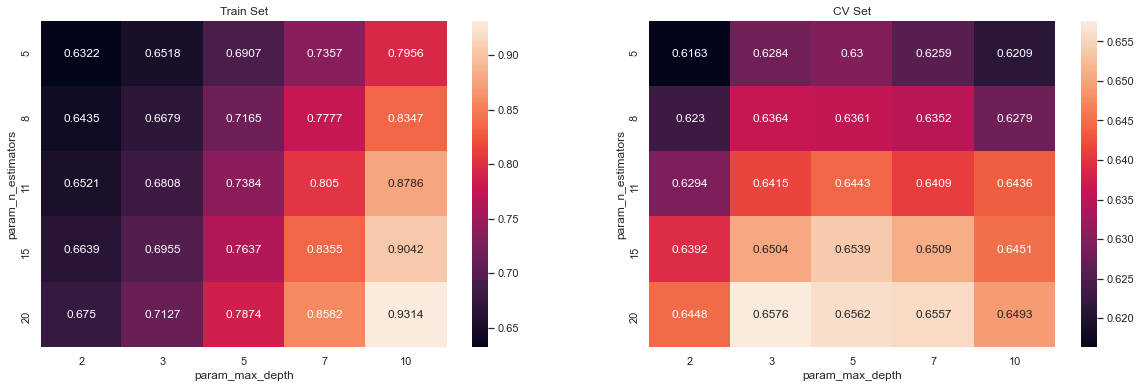

In [149]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
tfidf_gbdt = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
tfidf_gbdt .fit(X_tr_tfidf, Y_train)



max_scores1 = pd.DataFrame(tfidf_gbdt .cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

### observations
1.Good corelation between max depth 20 and sn_estimators 10

2.Good corelation between max depth 20 and sample split 5

In [155]:
print(tfidf_gbdt.best_estimator_)
#Mean cross-validated score of the best_estimator
print(tfidf_gbdt.score(X_tr_tfidf,Y_train))
print(tfidf_gbdt.score(X_te_tfidf,Y_test))


GradientBoostingClassifier(min_samples_split=15, n_estimators=20)
0.6978973392821376
0.6666342170622113


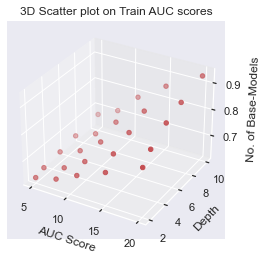

In [152]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,8,8,8,8,8,11,11,11,11,11,15,15,15,15,15,20,20,20,20,20]
second = [2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10]
third = list(tfidf_gbdt.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [170]:
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

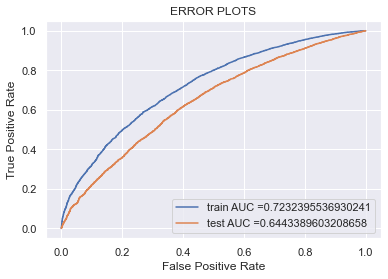

In [171]:
model1 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
model1.fit(X_tr_tfidf, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = model1.predict_proba(X_tr_tfidf) [:,1]
y_test_pred = model1.predict_proba(X_te_tfidf) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

In [172]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 2267  1196]
 [ 6327 12655]]
Accuracy score  for Train
0.6648251280908888
Test confusion matrix
[[1639  907]
 [6057 7897]]
Accuracy score  for Test
0.577939393939394


confusion matrix for train data


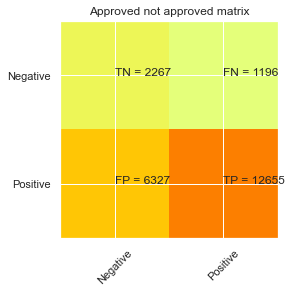

confusion matrix for Test data


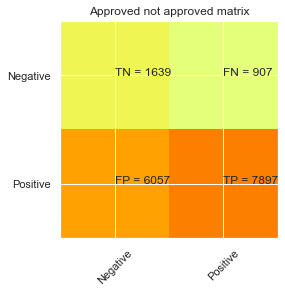

In [173]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 66% and test data is 57%.

## 4.3 GBDT on avgw2v

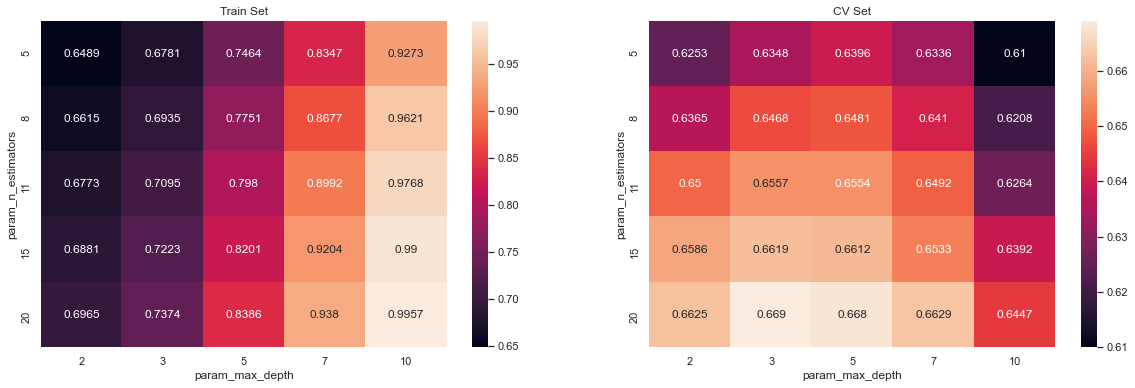

In [162]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
avgw2v_gbdt = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
avgw2v_gbdt .fit(X_tr_avgw2v, Y_train)



max_scores1 = pd.DataFrame(avgw2v_gbdt .cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

### observations
1.Good corelation between max depth 10 and sn_estimators 20

2.Good corelation between max depth 5 and sample split 20

In [163]:
print(avgw2v_gbdt.best_estimator_)
#Mean cross-validated score of the best_estimator
print(avgw2v_gbdt.score(X_tr_avgw2v,Y_train))
print(avgw2v_gbdt.score(X_te_avgw2v,Y_test))

GradientBoostingClassifier(min_samples_split=15, n_estimators=20)
0.7201905003974616
0.6719697961690083


In [174]:
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

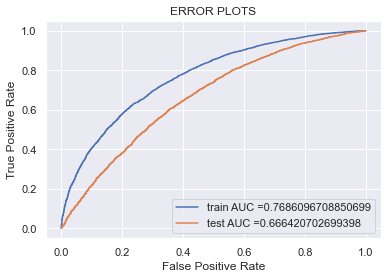

In [176]:
model1 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
model1.fit(X_tr_avgw2v, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = model1.predict_proba(X_tr_avgw2v) [:,1]
y_test_pred = model1.predict_proba(X_te_avgw2v) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

### observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

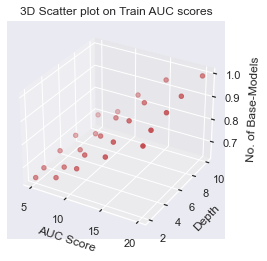

In [179]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,8,8,8,8,8,11,11,11,11,11,15,15,15,15,15,20,20,20,20,20]
second = [2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10]
third = list(avgw2v_gbdt.cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [180]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 2412  1051]
 [ 5725 13257]]
Accuracy score  for Train
0.698106482512809
Test confusion matrix
[[1566  980]
 [5162 8792]]
Accuracy score  for Test
0.6277575757575757


confusion matrix for train data


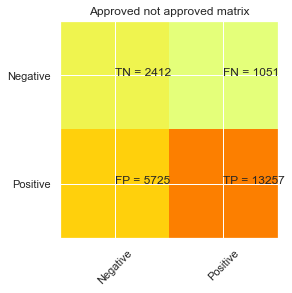

confusion matrix for Test data


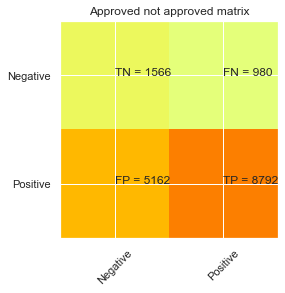

In [181]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations

1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 69% and test data is 62%.

## 4.4 TFIDFW2v

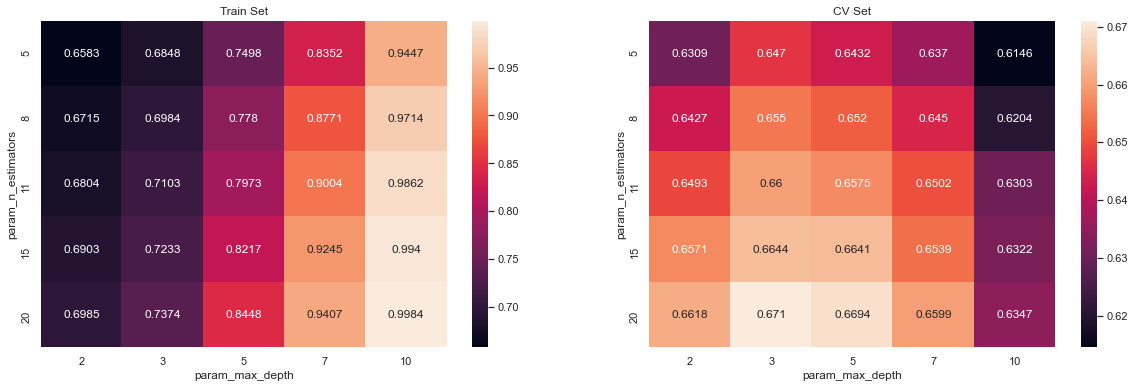

In [182]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(min_samples_split=15)
parameters = {'n_estimators': [5, 8,11,15,20], 'max_depth':[2, 3, 5, 7, 10] }
tfidfw2v_gbdt = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',return_train_score=True)
tfidfw2v_gbdt .fit(X_tr_tfidfw2v, Y_train)



max_scores1 = pd.DataFrame(tfidfw2v_gbdt .cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [185]:
print(tfidfw2v_gbdt.best_estimator_)
#Mean cross-validated score of the best_estimator
print(tfidfw2v_gbdt.score(X_tr_tfidfw2v,Y_train))
print(tfidfw2v_gbdt.score(X_te_tfidfw2v,Y_test))

GradientBoostingClassifier(min_samples_split=15, n_estimators=20)
0.7207962462302615
0.6732162043820111


In [186]:
best_tune_parameters=[{'n_estimators': [20], 'max_depth':[5] } ]

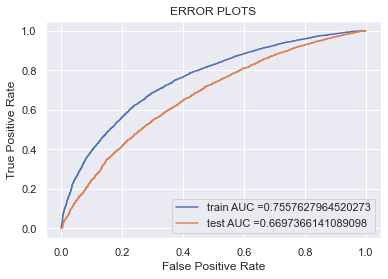

In [187]:
model1 = GridSearchCV(RandomForestClassifier(class_weight='balanced'),best_tune_parameters)
model1.fit(X_tr_tfidfw2v, Y_train)
#https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.ht
#sklearn.linear_model.SGDClassifier.decision_function
y_train_pred = model1.predict_proba(X_tr_tfidfw2v) [:,1]
y_test_pred = model1.predict_proba(X_te_tfidfw2v) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTS")
plt.grid(True)
plt.show()

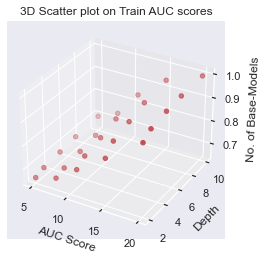

In [192]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

first = [5,5,5,5,5,8,8,8,8,8,11,11,11,11,11,15,15,15,15,15,20,20,20,20,20]
second = [2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10,2,3,5,7,10]
third = list(tfidfw2v_gbdt .cv_results_['mean_train_score'])



ax.scatter(first,second,third, c='r', marker='o')

ax.set_zlabel('No. of Base-Models')
ax.set_ylabel('Depth')
ax.set_xlabel('AUC Score')

plt.title('3D Scatter plot on Train AUC scores')
plt.show()

In [193]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_tfidfw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_tfidfw2v)
print("="*100)


Train confusion matrix
[[ 2438  1025]
 [ 6003 12979]]
Accuracy score  for Train
0.686879037647583
Test confusion matrix
[[1500 1046]
 [4773 9181]]
Accuracy score  for Test
0.6473333333333333


confusion matrix for train data


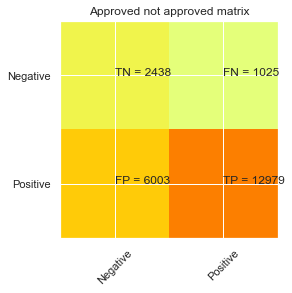

confusion matrix for Test data


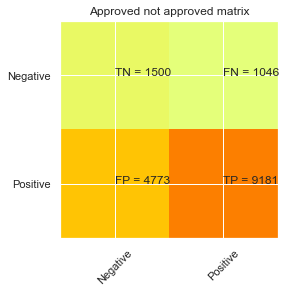

In [194]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)


### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 68% and test data is 64%

## 5.Performance 

In [183]:
from prettytable import PrettyTable
tb = PrettyTable()
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Model ", " Vectorizer ", " n_estimators", " max_depth "," Test -AUC")
tb.add_row([ "Random Forest", " BOW ", 1000,10, 69 ])
tb.add_row([ "Random Forest", " Tf - Idf",1000, 8, 70.3 ])
tb.add_row([ "Random Forest", " AVG-W2V", 1000, 7 , 68 ])
tb.add_row([ "Random Forest", " A VG-TfIdf",1000 , 7 , 68.2 ])
tb.add_row([ "Gradient Boosting DT", " Bow ",20 , 5 , 65 ])
tb.add_row([ "Gradient Boosting DT", " Tf-Idf",20 , 5 , 64.2 ])
tb.add_row([ "Gradient Boosting DT", " AVG-W2V", 20 , 5 , 66])
tb.add_row([ "Gradient Boosting DT", "A VG-TfIdf", 20 , 5 , 67 ])


### observation
1.Random forest gives best performance for  n_estimators=1000 max_depth=8 using TFIDF

2.GBDT gives best performance for  n_estimators=20 max_depth=5 using bow